# Proyek Klasifikasi Gambar: Pemandangan Alam di seluruh dunia
- **Nama:** Permata Ayu Rahmawati
- **Email:** permathaayu21@gmail.com
- **ID Dicoding:** permatayra

## Import Semua Packages/Library yang Digunakan

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
import zipfile
from google.colab import files
from google.colab import drive
import cv2
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
import tensorflowjs as tfjs
import os


## Data Preparation

### Data Loading

In [ ]:
# Upload kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Ekstrak dataset
with zipfile.ZipFile('intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('intel_images')

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [ ]:
# Hapus folder tidak perlu
!rm -rf intel_images/seg_pred

### Data Preprocessing

#### Split Dataset

In [ ]:
def create_split_folders():
    os.makedirs('intel_images_split/train', exist_ok=True)
    os.makedirs('intel_images_split/validation', exist_ok=True)
    os.makedirs('intel_images_split/test', exist_ok=True)

def split_dataset(source_dir, split_size=(0.7, 0.15, 0.15)):
    classes = os.listdir(source_dir)
    for cls in classes:
        if cls == '.DS_Store':
            continue

        # Buat folder tujuan per kelas
        train_dir = os.path.join('intel_images_split/train', cls)
        val_dir = os.path.join('intel_images_split/validation', cls)
        test_dir = os.path.join('intel_images_split/test', cls)

        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        # Ambil file gambar
        src = os.path.join(source_dir, cls)
        all_files = [f for f in os.listdir(src) if os.path.isfile(os.path.join(src, f))]

        # Warning jika data terlalu sedikit
        if len(all_files) < 5:
            print(f"[WARNING] Kelas '{cls}' hanya memiliki {len(all_files)} file. Folder test mungkin kosong.")

        np.random.shuffle(all_files)

        train_size = int(len(all_files) * split_size[0])
        val_size = int(len(all_files) * split_size[1])
        test_size = len(all_files) - train_size - val_size

        # Salin file ke folder masing-masing
        for f in all_files[:train_size]:
            shutil.copy2(os.path.join(src, f), os.path.join(train_dir, f))
        for f in all_files[train_size:train_size + val_size]:
            shutil.copy2(os.path.join(src, f), os.path.join(val_dir, f))
        for f in all_files[train_size + val_size:]:
            shutil.copy2(os.path.join(src, f), os.path.join(test_dir, f))

# Eksekusi
create_split_folders()
split_dataset('intel_images/seg_train/seg_train')


#### Preprocessing

In [ ]:
# Parameter
batch_size = 32
img_size = (224, 224)  # Meningkat dari 150x150

# Augmentasi data yang lebih moderat
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Generator untuk validasi dan test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_generator = train_datagen.flow_from_directory(
    'intel_images_split/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    'intel_images_split/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    'intel_images_split/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Hitung class weight untuk handling imbalance
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(train_generator.classes),
                                   y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

Found 9820 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 2112 images belonging to 6 classes.


## Modelling

In [ ]:
#Arsitektur model
def build_improved_model():
    model = keras.Sequential([
        # Blok 1
        layers.Conv2D(64, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        # Blok 2
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        # Blok 3
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        # Blok 4
        layers.Conv2D(512, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        # Head
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(6, activation='softmax')
    ])

    # Optimizer dengan learning rate decay
    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy',
                        keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall')])

    return model

model = build_improved_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,608,006 (9.95 MB)

 Trainable params: 2,606,086 (9.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# ========== 6. CALLBACKS ==========
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1),

    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1)
]

In [ ]:
# ========== 7. TRAINING ==========
epochs = 25

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4629 - loss: 1.3770 - precision: 0.5413 - recall: 0.3254
Epoch 1: val_accuracy improved from -inf to 0.30144, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 186s 530ms/step - accuracy: 0.4631 - loss: 1.3763 - precision: 0.5416 - recall: 0.3257 - val_accuracy: 0.3014 - val_loss: 2.6936 - val_precision: 0.3357 - val_recall: 0.1125 - learning_rate: 0.0010
Epoch 2/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 0.6250 - loss: 0.9263 - precision: 0.7308 - recall: 0.5938

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.30144 to 0.31779, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6250 - loss: 0.9263 - precision: 0.7308 - recall: 0.5938 - val_accuracy: 0.3178 - val_loss: 2.7839 - val_precision: 0.3448 - val_recall: 0.1159 - learning_rate: 0.0010
Epoch 3/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6577 - loss: 0.9035 - precision: 0.7172 - recall: 0.5510
Epoch 3: val_accuracy improved from 0.31779 to 0.65577, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 165s 481ms/step - accuracy: 0.6578 - loss: 0.9033 - precision: 0.7173 - recall: 0.5512 - val_accuracy: 0.6558 - val_loss: 0.8855 - val_precision: 0.7485 - val_recall: 0.5567 - learning_rate: 0.0010
Epoch 4/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.8750 - loss: 0.5728 - precision: 0.8519 - recall: 0.7188
Epoch 4: val_accuracy did not improve from 0.65577
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8750 - loss: 0.5728 - precision: 0.8519 - recall: 0.7188 - val_accuracy: 0.6495 - val_loss: 0.8993 - val_precision: 0.7271 - val_recall: 0.5688 - learning_rate: 0.0010
Epoch 5/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7244 - loss: 0.7357 - precision: 0.7801 - recall: 0.6534
Epoch 5: val_accuracy did not improve from 0.65577
306/306 ━━━━━━━━━━━━━━━━━━━━ 202s 658ms/step - accuracy: 0.7245 - loss: 0.7356 - precision: 0.7801 - recall: 0.6534 - val_accuracy: 0.5212 - val_loss: 1.3797 - val_precision: 0.5654 - val_recall: 

306/306 ━━━━━━━━━━━━━━━━━━━━ 202s 481ms/step - accuracy: 0.8014 - loss: 0.5456 - precision: 0.8383 - recall: 0.7554 - val_accuracy: 0.6731 - val_loss: 0.9058 - val_precision: 0.6940 - val_recall: 0.6433 - learning_rate: 5.0000e-04
Epoch 8/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.8438 - loss: 0.5403 - precision: 0.8621 - recall: 0.7812
Epoch 8: val_accuracy did not improve from 0.67308
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8438 - loss: 0.5403 - precision: 0.8621 - recall: 0.7812 - val_accuracy: 0.6687 - val_loss: 0.9255 - val_precision: 0.6933 - val_recall: 0.6380 - learning_rate: 5.0000e-04
Epoch 9/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8128 - loss: 0.5211 - precision: 0.8475 - recall: 0.7749
Epoch 9: val_accuracy improved from 0.67308 to 0.75865, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 202s 659ms/step - accuracy: 0.8129 - loss: 0.5211 - precision: 0.8475 - recall: 0.7749 - val_accuracy: 0.7587 - val_loss: 0.6411 - val_precision: 0.8114 - val_recall: 0.7115 - learning_rate: 5.0000e-04
Epoch 10/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 38s 125ms/step - accuracy: 0.8125 - loss: 0.4586 - precision: 0.8065 - recall: 0.7812
Epoch 10: val_accuracy improved from 0.75865 to 0.76202, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8125 - loss: 0.4586 - precision: 0.8065 - recall: 0.7812 - val_accuracy: 0.7620 - val_loss: 0.6420 - val_precision: 0.8133 - val_recall: 0.7120 - learning_rate: 5.0000e-04
Epoch 11/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8266 - loss: 0.4841 - precision: 0.8544 - recall: 0.7968
Epoch 11: val_accuracy improved from 0.76202 to 0.82212, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 202s 660ms/step - accuracy: 0.8266 - loss: 0.4841 - precision: 0.8544 - recall: 0.7969 - val_accuracy: 0.8221 - val_loss: 0.4931 - val_precision: 0.8505 - val_recall: 0.7880 - learning_rate: 5.0000e-04
Epoch 12/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - accuracy: 0.7500 - loss: 0.5861 - precision: 0.7778 - recall: 0.6562
Epoch 12: val_accuracy did not improve from 0.82212
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7500 - loss: 0.5861 - precision: 0.7778 - recall: 0.6562 - val_accuracy: 0.8053 - val_loss: 0.5287 - val_precision: 0.8405 - val_recall: 0.7678 - learning_rate: 5.0000e-04
Epoch 13/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8409 - loss: 0.4433 - precision: 0.8663 - recall: 0.8133
Epoch 13: val_accuracy did not improve from 0.82212
306/306 ━━━━━━━━━━━━━━━━━━━━ 143s 466ms/step - accuracy: 0.8409 - loss: 0.4433 - precision: 0.8663 - recall: 0.8133 - val_accuracy: 0.7385 - val_loss: 0.6423 - val_precision: 0.7641 - 

306/306 ━━━━━━━━━━━━━━━━━━━━ 202s 661ms/step - accuracy: 0.8612 - loss: 0.3835 - precision: 0.8821 - recall: 0.8411 - val_accuracy: 0.8567 - val_loss: 0.3876 - val_precision: 0.8756 - val_recall: 0.8389 - learning_rate: 2.5000e-04
Epoch 16/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - accuracy: 0.8438 - loss: 0.3653 - precision: 0.8438 - recall: 0.8438
Epoch 16: val_accuracy improved from 0.85673 to 0.86154, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8438 - loss: 0.3653 - precision: 0.8438 - recall: 0.8438 - val_accuracy: 0.8615 - val_loss: 0.3917 - val_precision: 0.8746 - val_recall: 0.8385 - learning_rate: 2.5000e-04
Epoch 17/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8749 - loss: 0.3549 - precision: 0.8918 - recall: 0.8566
Epoch 17: val_accuracy did not improve from 0.86154
306/306 ━━━━━━━━━━━━━━━━━━━━ 142s 465ms/step - accuracy: 0.8749 - loss: 0.3549 - precision: 0.8918 - recall: 0.8566 - val_accuracy: 0.8524 - val_loss: 0.4254 - val_precision: 0.8722 - val_recall: 0.8303 - learning_rate: 2.5000e-04
Epoch 18/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.8750 - loss: 0.3737 - precision: 0.8966 - recall: 0.8125
Epoch 18: val_accuracy did not improve from 0.86154

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8750 - loss: 0.3737 - precision: 0.8966 - recall: 

306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9688 - loss: 0.1784 - precision: 1.0000 - recall: 0.9375 - val_accuracy: 0.8625 - val_loss: 0.4184 - val_precision: 0.8746 - val_recall: 0.8486 - learning_rate: 1.2500e-04
Epoch 21/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8890 - loss: 0.2987 - precision: 0.9045 - recall: 0.8738
Epoch 21: val_accuracy improved from 0.86250 to 0.88462, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 202s 660ms/step - accuracy: 0.8890 - loss: 0.2987 - precision: 0.9045 - recall: 0.8738 - val_accuracy: 0.8846 - val_loss: 0.3448 - val_precision: 0.8987 - val_recall: 0.8745 - learning_rate: 1.2500e-04
Epoch 22/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - accuracy: 0.8438 - loss: 0.3220 - precision: 0.8387 - recall: 0.8125
Epoch 22: val_accuracy did not improve from 0.88462
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8438 - loss: 0.3220 - precision: 0.8387 - recall: 0.8125 - val_accuracy: 0.8846 - val_loss: 0.3405 - val_precision: 0.8985 - val_recall: 0.8764 - learning_rate: 1.2500e-04
Epoch 23/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8931 - loss: 0.2953 - precision: 0.9087 - recall: 0.8783
Epoch 23: val_accuracy improved from 0.88462 to 0.88702, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 147s 480ms/step - accuracy: 0.8931 - loss: 0.2953 - precision: 0.9087 - recall: 0.8782 - val_accuracy: 0.8870 - val_loss: 0.3209 - val_precision: 0.8985 - val_recall: 0.8808 - learning_rate: 1.2500e-04
Epoch 24/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.8750 - loss: 0.3034 - precision: 0.9032 - recall: 0.8750
Epoch 24: val_accuracy did not improve from 0.88702
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8750 - loss: 0.3034 - precision: 0.9032 - recall: 0.8750 - val_accuracy: 0.8870 - val_loss: 0.3215 - val_precision: 0.9003 - val_recall: 0.8813 - learning_rate: 1.2500e-04
Epoch 25/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8992 - loss: 0.2739 - precision: 0.9102 - recall: 0.8869
Epoch 25: val_accuracy improved from 0.88702 to 0.89231, saving model to best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 147s 481ms/step - accuracy: 0.8992 - loss: 0.2739 - precision: 0.9102 - recall: 0.8869 - val_accuracy: 0.8923 - val_loss: 0.3033 - val_precision: 0.9028 - val_recall: 0.8841 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 25.


## Evaluasi dan Visualisasi

In [ ]:
# Evaluasi pada test set
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_prec:.4f}')
print(f'Test Recall: {test_rec:.4f}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8920 - loss: 0.2879 - precision: 0.9035 - recall: 0.8836

Test Accuracy: 0.8835
Test Precision: 0.8947
Test Recall: 0.8769


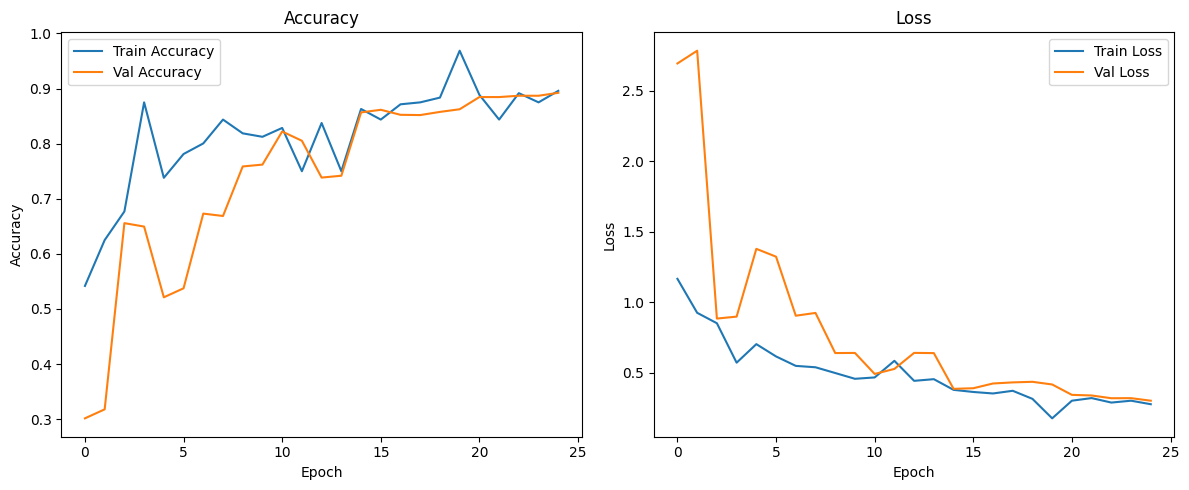

In [ ]:
#visualisasi
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

## Konversi Model

In [ ]:
# # Konversi model ke format TFLite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Path yang benar ke folder di Google Drive
# tflite_path = '/content/drive/MyDrive/Belajar_pengembangan_ML/submission_klasifikasi/intel_classifier_improved.tflite'

# # Simpan model ke Drive
# with open(tflite_path, 'wb') as f:
#     f.write(tflite_model)

# print(f"Berhasil disimpan di: {tflite_path}")


Saved artifact at '/tmp/tmperce67ks'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133488795339472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795340240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795342928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795343312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795339088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795342544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795341200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795343888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795344272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795341776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13348879534408

In [ ]:
# Path direktori submission
base_dir = '/content/drive/MyDrive/Belajar_pengembangan_ML/submission_klasifikasi'
saved_model_dir = os.path.join(base_dir, 'saved_model')
tfjs_model_dir = os.path.join(base_dir, 'tfjs_model')
tflite_model_dir = os.path.join(base_dir, 'tflite')

os.makedirs(saved_model_dir, exist_ok=True)
os.makedirs(tfjs_model_dir, exist_ok=True)
os.makedirs(tflite_model_dir, exist_ok=True)

# =====================
# Simpan SavedModel (untuk model Keras)
model.export(saved_model_dir)
print("Model berhasil disimpan sebagai SavedModel!")

# =====================
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
tflite_path = os.path.join(tflite_model_dir, 'model.tflite')

with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model berhasil dikonversi ke TFLite dan disimpan di: {tflite_path}")

# Simpan label
class_labels = list(train_generator.class_indices.keys())
with open(os.path.join(tflite_model_dir, 'label.txt'), 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

# =====================
# Konversi ke TFJS
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model berhasil dikonversi ke TensorFlow.js dan disimpan di: {tfjs_model_dir}")


Saved artifact at '/content/drive/MyDrive/Belajar_pengembangan_ML/submission_klasifikasi/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133488795339472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795340240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795342928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795343312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795339088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795342544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795341200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795343888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795344272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133488795341776: Te

Model berhasil dikonversi ke TFLite dan disimpan di: /content/drive/MyDrive/Belajar_pengembangan_ML/submission_klasifikasi/tflite/model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke TensorFlow.js dan disimpan di: /content/drive/MyDrive/Belajar_pengembangan_ML/submission_klasifikasi/tfjs_model


## Inference (Optional)